In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.Joint100Env import JointEnvironment
from learners.joint.JointTS import JointTS
from learners.pricing.ucb import UCB

In [3]:
data_gen = BasicDataGenerator(filename='src/basic001.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'{prices=}')
print(f'{bids=}')
print(f'{margins=}')
print(f'{conv_rates=}')
print(f'{costs_per_click=}')
print(f'{n_clicks=}')
print(f'{aggr_tau=}')

arms = np.array(np.meshgrid(margins, bids)).T.reshape(len(margins)*len(bids), 2)
n_arms = len(arms)
env_params = {
        'mode': 'aggregate',
        'src': 'src/basic001.json',
}

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.03, 0.04, 0.07, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0]
margins=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
conv_rates=array([0.213, 0.207, 0.2  , 0.19 , 0.176, 0.16 , 0.132, 0.122, 0.112,
       0.094])
costs_per_click=array([0.03 , 0.04 , 0.069, 0.097, 0.189, 0.44 , 0.626, 0.796, 1.1  ,
       1.367])
n_clicks=array([ 28.807,  37.296,  59.959,  79.058, 124.63 , 183.261, 199.824,
       206.816, 211.296, 212.237])
aggr_tau=array([2.85 , 2.485, 2.12 , 1.755, 1.39 , 1.025, 0.84 , 0.69 , 0.65 ,
       0.65 ])


In [34]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [35]:
margins_rep = np.repeat(margins, len(margins))
conv_rates_rep = np.repeat(conv_rates, len(margins))
n_clicks_tile = np.tile(n_clicks, len(bids))
costs_per_click_tile = np.tile(costs_per_click, len(bids))
tau_rep = np.repeat(aggr_tau, len(margins))

In [36]:
opt_arm = np.argmax((margins_rep * conv_rates_rep * (1 + tau_rep) - costs_per_click_tile) * n_clicks_tile)
print(f'N_ARMS: {n_arms}')
print(f'Arms:\n {arms}')
print(f'Optimal arm: {str(opt_arm)}')

N_ARMS: 100
Arms:
 [[15.    0.03]
 [15.    0.04]
 [15.    0.07]
 [15.    0.1 ]
 [15.    0.2 ]
 [15.    0.5 ]
 [15.    0.75]
 [15.    1.  ]
 [15.    1.5 ]
 [15.    2.  ]
 [16.    0.03]
 [16.    0.04]
 [16.    0.07]
 [16.    0.1 ]
 [16.    0.2 ]
 [16.    0.5 ]
 [16.    0.75]
 [16.    1.  ]
 [16.    1.5 ]
 [16.    2.  ]
 [17.    0.03]
 [17.    0.04]
 [17.    0.07]
 [17.    0.1 ]
 [17.    0.2 ]
 [17.    0.5 ]
 [17.    0.75]
 [17.    1.  ]
 [17.    1.5 ]
 [17.    2.  ]
 [18.    0.03]
 [18.    0.04]
 [18.    0.07]
 [18.    0.1 ]
 [18.    0.2 ]
 [18.    0.5 ]
 [18.    0.75]
 [18.    1.  ]
 [18.    1.5 ]
 [18.    2.  ]
 [19.    0.03]
 [19.    0.04]
 [19.    0.07]
 [19.    0.1 ]
 [19.    0.2 ]
 [19.    0.5 ]
 [19.    0.75]
 [19.    1.  ]
 [19.    1.5 ]
 [19.    2.  ]
 [20.    0.03]
 [20.    0.04]
 [20.    0.07]
 [20.    0.1 ]
 [20.    0.2 ]
 [20.    0.5 ]
 [20.    0.75]
 [20.    1.  ]
 [20.    1.5 ]
 [20.    2.  ]
 [21.    0.03]
 [21.    0.04]
 [21.    0.07]
 [21.    0.1 ]
 [21.    0.2 ]
 [21. 

In [37]:
learners_to_test = [JointTS]
rewards_per_experiment = []

print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')

N_ROUNDS: 365
N_EXPERIMENTS: 10


In [38]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'running exp#{e}...')
    test_instances = []
    learner = JointTS(arm_values = arms)
    env = JointEnvironment(**env_params)
    for t in range(T):
        learner.next_day()
        month_purchases = env.get_next_purchases_at_day(t, keep=False)
        if month_purchases is not None:
            pulled_arms = env.get_selected_arms_at_day(t - 30, keep=False)
            for arm, n_purchases in zip(pulled_arms, month_purchases):
                learner.update_single_future_purchase(arm, n_purchases)
        pulled_arm = learner.pull_arm()
        daily_reward = env.day_round(pulled_arm)
        for outcome, cost in daily_reward:
            learner.update(pulled_arm, outcome, cost)

    rewards_per_experiment.append(learner.daily_collected_rewards)

running exp#0...
Environment created with no fixed arm values
running exp#1...
Environment created with no fixed arm values
running exp#2...
Environment created with no fixed arm values
running exp#3...
Environment created with no fixed arm values
running exp#4...
Environment created with no fixed arm values
running exp#5...
Environment created with no fixed arm values
running exp#6...
Environment created with no fixed arm values
running exp#7...
Environment created with no fixed arm values
running exp#8...
Environment created with no fixed arm values
running exp#9...
Environment created with no fixed arm values


In [39]:
len(rewards_per_experiment[0])

364

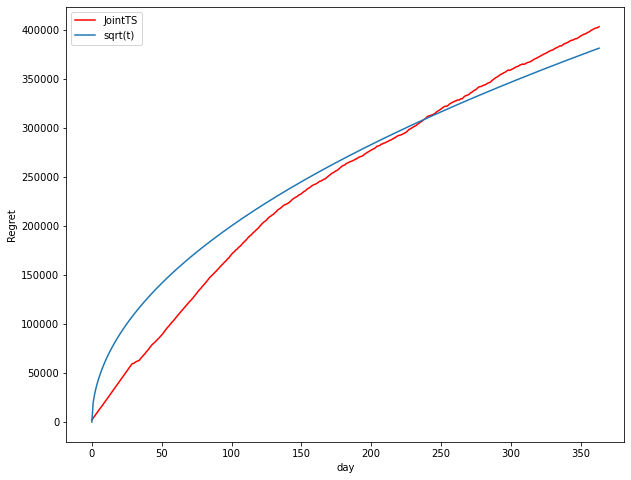

In [46]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
opt = (margins_rep[opt_arm] * conv_rates_rep[opt_arm] * (1 + tau_rep[opt_arm]) - costs_per_click_tile[opt_arm]) * np.rint(n_clicks_tile[opt_arm]).astype(int)
plt.plot(np.cumsum(np.mean(opt - rewards_per_experiment, axis=0)), 'r')
plt.plot(20000*np.sqrt(np.linspace(0,364,364)))
#for val in rewards_per_experiment.values():
#    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(['JointTS', 'sqrt(t)'])
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

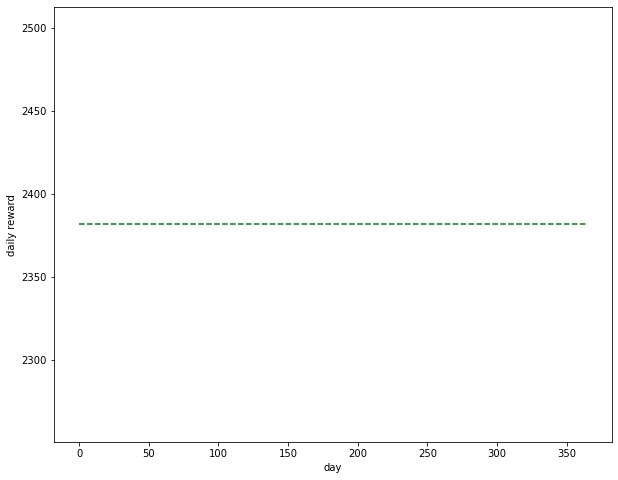

In [11]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*365, '--g', label='clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)
plt.legend(loc='best')
plt.show()